
The purpose of this notebook is to determine the readability or unreadability of code generated by LLM using another LLM as a Judge / Evaluator.

## Install Dependencies and Import Libraries

In [1]:
!pip install -qq "arize-phoenix-evals>=0.0.5" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio 'httpx<0.28'
!pip install mistralai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.6/608.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.5/262.5 kB 15.6 MB/s eta 0:00:00


In [2]:
N_EVAL_SAMPLE_SIZE = 20

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

from phoenix.evals import (
    CODE_READABILITY_PROMPT_RAILS_MAP,
    CODE_READABILITY_PROMPT_TEMPLATE,
    OpenAIModel,
    MistralAIModel,
    download_benchmark_dataset,
    llm_classify,
)

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the system consisting of an LLM model which was used to generate implementation code, using an evaluation prompt template against a benchmark dataset of readable and unreadable code with ground-truth labels. For this task we look at the following dataset:

- openai_humaneval_with_readability

In [5]:
dataset_name = "openai_humaneval_with_readability"
df = download_benchmark_dataset(task="code-readability-classification", dataset_name=dataset_name)
df.head()

,Unnamed: 0,task_id,prompt,canonical_solution,test,entry_point,readable,solution
0,0,HumanEval/0,"from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n """""" Check if in given list of numbers, are any two numbers closer to each other than\n given threshold.\n >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n False\n >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n True\n """"""\n","for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n","\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.3) == True\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.05) == False\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.95) == True\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.8) == False\n assert candidate([1.0, 2.0, 3.0, 4.0, 5.0, 2.0], 0.1) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 1.0) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 0.5) == False\n\n",has_close_elements,True,"for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n"
1,1,HumanEval/1,"from typing import List\n\n\ndef separate_paren_groups(paren_string: str) -> List[str]:\n """""" Input to this function is a string containing multiple groups of nested parentheses. Your goal is to\n separate those group into separate strings and return the list of those.\n Separate groups are balanced (each open brace is properly closed) and not nested within each other\n Ignore any spaces in the input string.\n >>> separate_paren_groups('( ) (( )) (( )( ))')\n ['()', '(())', '(()())']\n """"""\n",result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate('(()()) ((())) () ((())()())') == [\n '(()())', '((()))', '()', '((())()())'\n ]\n assert candidate('() (()) ((())) (((())))') == [\n '()', '(())', '((()))', '(((())))'\n ]\n assert candidate('(()(())((())))') == [\n '(()(())((())))'\n ]\n assert candidate('( ) (( )) (( )( ))') == ['()', '(())', '(()())']\n",separate_paren_groups,True,result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n
2,2,HumanEval/2,"\n\ndef truncate_number(number: float) -> float:\n """""" Given a positive floating point number, it can be decomposed into\n and integer part (largest integer smaller than given number) and decimals\n (leftover part always smaller than 1).\n\n Return the decimal part of the number.\n >>> truncate_number(3.5)\n 0.5\n """"""\n",return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate(3.5) == 0.5\n assert abs(candidate(1.33) - 0.33) < 1e-6\n assert abs(candidate(123.456) - 0.456) < 1e-6\n",truncate_number,False,return((lambda x: (lambda y: y(x))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u)))))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u))))(lambda f: lambda x: x if x == 0 else f(x - 1) + 1)(number % 1.0))
3,3,HumanEval/3,"from typing import List\n\n\ndef below_zero(operations: List[int]) -> bool:\n """""" You're given a list of deposit and withdrawal operations on a ban

Binary Readability Classification Template


In [6]:
print(CODE_READABILITY_PROMPT_TEMPLATE)


You are a stern but practical senior software engineer who cares a lot about simplicity and
readability of code. Can you review the following code that was written by another engineer?
Focus on readability of the code. Respond with "readable" if you think the code is readable,
or "unreadable" if the code is unreadable or needlessly complex for what it's trying
to accomplish.

ONLY respond with "readable" or "unreadable"

Task Assignment:
```
{input}
```

Implementation to Evaluate:
```
{output}
```



The template variables are:

- **input:** the query from the user describing the coding task
- **output:** an implementation of the coding task

## Configure the  LLM Judge / Evaluator

Configure your MISTRALAI API key.

In [7]:
if not (mistralai_api_key := os.getenv("MISTRALAI_API_KEY")):
    mistralai_api_key = getpass("🔑 Enter your MISTRALAI API key: ")
os.environ["MISTRALAI_API_KEY"] = mistralai_api_key

🔑 Enter your MISTRALAI API key: ··········


Instantiate the LLM Judge / Evaluator and set parameters.


In [8]:
model = MistralAIModel(
    model="codestral-mamba-2407",
    temperature=0.0,
    api_key=mistralai_api_key,
)

Simple test to show that we are able call the model

In [9]:
model("Hello, are you ready to classify code as readable or not?")

"Hello! I'm here to help you with your question. However, I need more information to provide a meaningful response. Could you please provide the code you want to classify as readable or not? Additionally, it would be helpful if you could specify the programming language of the code."

## Sample Benchmark Dataset
Sample size determines run time

In [10]:
df = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)
df = df.rename(
    columns={"prompt": "input", "solution": "output"},
)
codet5_df  = df.copy()



## LLM Code Readability Classifications

Run readability classifications against a subset of the data.

In [11]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=1,
    verbose=True,
    provide_explanation=True,
    max_retries=20,
    run_sync=False,
)["label"].tolist()

Using prompt:

[PromptPartTemplate(content_type=<PromptPartContentType.TEXT: 'text'>, template='\nYou are a stern but practical senior software engineer who cares a lot about simplicity and\nreadability of code. Can you review the following code that was written by another engineer?\nFocus on readability of the code. The implementation is "readable" if you think the code is\nreadable, or "unreadable" if the code is unreadable or needlessly complex for what it\'s trying\nto accomplish.\n\nTask Assignment:\n```\n{input}\n```\n\nImplementation to Evaluate:\n```\n{output}\n```\n\nPlease read the code carefully, then write out in a step by step manner an EXPLANATION to show how\nto evaluate the readability of the code. Avoid simply stating the correct answer at the outset.\nYour response LABEL must be a single word, either "readable" or "unreadable", and should not\ncontain any text or characters aside from that. "readable" means that the code is readable.\n"unreadable" means the code is un

<ipython-input-11-56a93cf1f06c>:5: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  readability_classifications = llm_classify(


llm_classify |          | 0/20 (0.0%) | ⏳ 00:00<? | ?it/s

- Snapped 'readable"' to rail: readable
- Snapped 'unreadable"' to rail: unreadable
- Snapped 'unreadable"' to rail: unreadable
- Snapped 'readable"\n\nExplanation: The code is simple, straightforward, and easy to understand. It uses a built-in Python method to concatenate a list of strings into a single string, which is a common and straightforward task. The function is well-documented, making it easy to understand its purpose and usage.' to rail: readable
- Snapped 'readable"\n\nExplanation: The code is now more readable because it uses a clear function name, type hints, and simple arithmetic operations. The use of a try-except block is unnecessary and has been removed. The function now simply adds x and y and returns the result.' to rail: readable
- Snapped 'readable"' to rail: readable
- Snapped 'readable"\n\nThe code is readable because it uses a straightforward and efficient approach to find the maximum element in a list. The variable names are clear and the code is well-commente


Evaluate the predictions against human-labeled ground-truth readability labels.

              precision    recall  f1-score   support

    readable       0.44      1.00      0.61         7
  unreadable       1.00      0.23      0.38        13

   micro avg       0.53      0.50      0.51        20
   macro avg       0.72      0.62      0.49        20
weighted avg       0.80      0.50      0.46        20



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

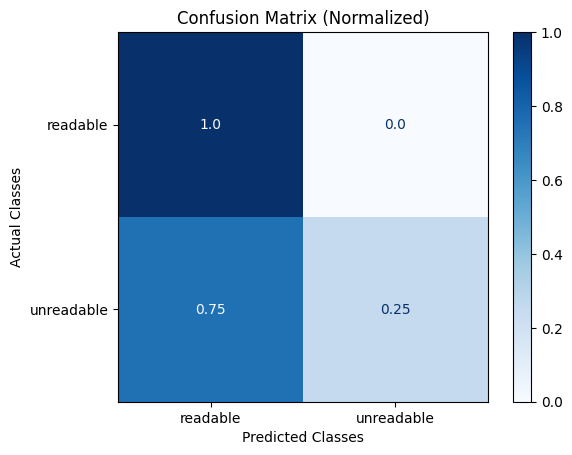

In [12]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, readability_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=readability_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Inspecting evaluations

Because the evals are binary classifications, we can easily sample a few rows
where the evals deviated from ground truth and see what the actual code was in
that case.

In [13]:
df["readability"] = readability_classifications
# inspect instances where ground truth was readable but evaluated to unreadable by the LLM
filtered_df = df.query('readable == False and readability == "readable"')

# inspect first 5 rows that meet this condition
result = filtered_df.head(5)
result

,Unnamed: 0,task_id,input,canonical_solution,test,entry_point,readable,output,readability
4,53,HumanEval/53,"\n\ndef add(x: int, y: int):\n """"""Add two numbers x and y\n >>> add(2, 3)\n 5\n >>> add(5, 7)\n 12\n """"""\n",return x + y\n,"\n\nMETADATA = {}\n\n\ndef check(candidate):\n import random\n\n assert candidate(0, 1) == 1\n assert candidate(1, 0) == 1\n assert candidate(2, 3) == 5\n assert candidate(5, 7) == 12\n assert candidate(7, 5) == 12\n\n for i in range(100):\n x, y = random.randint(0, 1000), random.randint(0, 1000)\n assert candidate(x, y) == x + y\n\n",add,False,"def add_two_numbers(x, y):\n try:\n if not isinstance(x, (int, float)) or not isinstance(y, (int, float)):\n raise ValueError(""Both arguments must be either int or float."")\n else:\n result = 0\n for i in range(abs(int(x))):\n result += 1 if x > 0 else -1\n for i in range(abs(int(y))):\n result += 1 if y > 0 else -1\n decimal_x = abs(x) - abs(int(x))\n decimal_y = abs(y) - abs(int(y))\n decimal_result = decimal_x + decimal_y\n if decimal_result >= 1:\n result += 1 if (x > 0 and y > 0) or (x < 0 and y < 0) else -1\n decimal_result -= 1\n result += decimal_result if (x > 0 and y > 0) or (x < 0 and y < 0) else -decimal_result\n return result\n except ValueError as e:\n print(e)",readable
7,29,HumanEval/29,"from typing import List\n\n\ndef filter_by_prefix(strings: List[str], prefix: str) -> List[str]:\n """""" Filter an input list of strings only for ones that start with a given prefix.\n >>> filter_by_prefix([], 'a')\n []\n >>> filter_by_prefix(['abc', 'bcd', 'cde', 'array'], 'a')\n ['abc', 'array']\n """"""\n",return [x for x in strings if x.startswith(prefix)]\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([], 'john') == []\n assert candidate(['xxx', 'asd', 'xxy', 'john doe', 'xxxAAA', 'xxx'], 'xxx') == ['xxx', 'xxxAAA', 'xxx']\n",filter_by_prefix,False,"return list(filter(lambda x: x[:len(prefix)] == prefix, strings))",readable
8,94,HumanEval/94,"\n\ndef skjkasdkd(lst):\n """"""You are given a list of integers.\n You need to find the largest prime value and return the sum of its digits.\n\n Examples:\n For lst = [0,3,2,1,3,5,7,4,5,5,5,2,181,32,4,32,3,2,32,324,4,3] the output should be 10\n For lst = [1,0,1,8,2,4597,2,1,3,40,1,2,1,2,4,2,5,1] the output should be 25\n For lst = [1,3,1,32,5107,34,83278,109,163,23,2323,32,30,1,9,3] the output should be 13\n For lst = [0,724,32,71,99,32,6,0,5,91,83,0,5,6] the output should be 11\n For lst = [0,81,12,3,1,21] the output should be 3\n For lst = [0,8,1,2,1,7] the output should be 7\n """"""\n","def isPrime(n):\n for i in range(2,int(n**0.5)+1):\n if n%i==0:\n return False\n\n return True\n maxx = 0\n i = 0\n while i < len(lst):\n if(lst[i] > maxx and isPrime(lst[i])):\n maxx = lst[i]\n i+=1\n result = sum(int(digit) for digit in str(maxx))\n return result\n\n","def check(candidate):\n\n # Check some simple cases\n assert candidate([0,3,2,1,3,5,7,4,5,5,5,2,181,32,4,32,3,2,32,324,4,3]) == 10, ""This prints if this assert fails 1 (good for debugging!)""\n\n # Check some edge cases that are easy to work out by hand.\n assert candidate([1,0,1,8,2,4597,2,1,3,40,1,2,1,2,4,2,5,1]) == 25, ""This prints if this assert fails 2 (also good for debugging!)""\n\n # Check some edge cases that are easy to work out by hand.\n assert candidate([1,3,1,32,5107,34,83278,109,163,23,2323,32,30,1,9,3]) == 13, ""This prints if this assert fails 3 (also good for debugging!)""\n\n # Check some edge cases that are easy to work out by hand.\n assert candidate([0,724,32,71,99,32,6,0,5,91,83,0,5,6]) == 11, ""This prints if this assert fails 4 (also good for debugging!)""\n \n # Check some edge cases that are easy to work out by hand.\n assert candidate([0,81,12,3,1,21]) == 3, ""This prints if this assert fails 5 (also good for debugging!)""\n\n # Check some edge cases that are easy to work out by hand.\n assert candidate([0,8,1,2,1,7]) == 7, ""This prints if this assert fails 6 (

In [15]:
from huggingface_hub import login

# Replace 'your_hf_token' with your actual token
login(token=HF_TOKEN)

In [16]:
from transformers import RobertaTokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-large-ntp-py")
gen_model = T5ForConditionalGeneration.from_pretrained("Salesforce/codet5-large-ntp-py")

tokenizer_config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/511k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

In [17]:
# Pick an example index
index = 1
# Generate input prompt
prompt = df["input"].iloc[index]
entry_point = df["entry_point"].iloc[index]
input_text = f"""
You are a Python expert. Here is a task you need to complete:
{prompt}.

Please implement the function named '{entry_point}' and only return the code inside the function named {entry_point}. Remove any other text or explanation.

Make sure to use correct Python syntax.
"""


inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

# Generate code
output = gen_model.generate(**inputs, max_length=128)
generated_code = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated Code:\n", generated_code)

Generated Code:
 
"""

def is_bored(S):
    """
    You'll be given a string of words, and your task to count the number
    of boredoms. A boredom is a sentence that starts with the word "I".
    Sentences are delimited by '.', '?' or '!'.
   
    For example:
    >>> is_bored("Hello world")
    0
    >>> is_bored("The sky is blue. The sun is shining. I love this weather")
    1
    """
    bored = 0



In [18]:
new_df = df.loc[[index]].copy()
new_df["output"] = generated_code

In [19]:
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=new_df,
    template=CODE_READABILITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=1,
    verbose=True,
    provide_explanation=True,
    max_retries=20,
    run_sync=False,
)["label"].tolist()

Using prompt:

[PromptPartTemplate(content_type=<PromptPartContentType.TEXT: 'text'>, template='\nYou are a stern but practical senior software engineer who cares a lot about simplicity and\nreadability of code. Can you review the following code that was written by another engineer?\nFocus on readability of the code. The implementation is "readable" if you think the code is\nreadable, or "unreadable" if the code is unreadable or needlessly complex for what it\'s trying\nto accomplish.\n\nTask Assignment:\n```\n{input}\n```\n\nImplementation to Evaluate:\n```\n{output}\n```\n\nPlease read the code carefully, then write out in a step by step manner an EXPLANATION to show how\nto evaluate the readability of the code. Avoid simply stating the correct answer at the outset.\nYour response LABEL must be a single word, either "readable" or "unreadable", and should not\ncontain any text or characters aside from that. "readable" means that the code is readable.\n"unreadable" means the code is un

<ipython-input-19-cce16206b894>:2: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  readability_classifications = llm_classify(


llm_classify |          | 0/1 (0.0%) | ⏳ 00:00<? | ?it/s

- Snapped 'ed as "unreadable" because the function body is empty and does not contain any logic to count the number of boredoms.\n\nHere is the final evaluation:\n\n```\n************\nEXPLANATION: The code is unreadable because the function body is empty and does not contain any logic to count the number of boredoms.\nLABEL: "unreadable"\n************\n```' to rail: unreadable


In [20]:

for index in range(N_EVAL_SAMPLE_SIZE):
  # Generate input prompt
  prompt = df["input"].iloc[index]
  entry_point = df["entry_point"].iloc[index]
  input_text = f"""
  You are a Python expert. Here is a task you need to complete:
  {prompt}.

  Please implement the function named '{entry_point}' and only return the code inside the function named {entry_point}. Remove any other text or explanation.

  Make sure to use correct Python syntax.
  """


  inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True)

  # Generate code
  output = gen_model.generate(**inputs, max_length=256)
  generated_code = tokenizer.decode(output[0], skip_special_tokens=True)
  codet5_df.loc[index, "output"] = generated_code


In [21]:
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications_codet5 = llm_classify(
    dataframe=codet5_df,
    template=CODE_READABILITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=1,
    verbose=True,
    provide_explanation=True,
    max_retries=20,
    run_sync=False,
)["label"].tolist()

Using prompt:

[PromptPartTemplate(content_type=<PromptPartContentType.TEXT: 'text'>, template='\nYou are a stern but practical senior software engineer who cares a lot about simplicity and\nreadability of code. Can you review the following code that was written by another engineer?\nFocus on readability of the code. The implementation is "readable" if you think the code is\nreadable, or "unreadable" if the code is unreadable or needlessly complex for what it\'s trying\nto accomplish.\n\nTask Assignment:\n```\n{input}\n```\n\nImplementation to Evaluate:\n```\n{output}\n```\n\nPlease read the code carefully, then write out in a step by step manner an EXPLANATION to show how\nto evaluate the readability of the code. Avoid simply stating the correct answer at the outset.\nYour response LABEL must be a single word, either "readable" or "unreadable", and should not\ncontain any text or characters aside from that. "readable" means that the code is readable.\n"unreadable" means the code is un

<ipython-input-21-4f84ba3ff771>:2: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  readability_classifications_codet5 = llm_classify(


llm_classify |          | 0/20 (0.0%) | ⏳ 00:00<? | ?it/s

- Snapped 'readable"' to rail: readable
- Snapped 'readable"' to rail: readable
- Snapped 'readable"\n\n************\nEXPLANATION: The code is readable because it has a clear function name, documentation, and variable names. The function body is concise and easy to understand, and the return statement is clear and concise. Adding comments to explain the purpose of the function and the logic behind the return statement would further improve readability.\n************\n```python\ndef search(lst):\n    \'\'\'\n    You are given a non-empty list of positive integers. Return the greatest integer that is greater than\n    zero, and has a frequency greater than or equal to the value of the integer itself.\n    The frequency of an integer is the number of times it appears in the list.\n    If no such a value exist, return -1.\n    Examples:\n        search([4, 1, 2, 2, 3, 1]) == 2\n        search([1, 2, 2, 3, 3, 3, 4, 4, 4]) == 3\n        search([5, 5, 4, 4, 4]) == -1\n    \'\'\'\n    pass\n\n

In [22]:
print(readability_classifications_codet5)

['readable', 'readable', 'readable', 'readable', 'readable', 'readable', 'readable', 'readable', 'NOT_PARSABLE', 'NOT_PARSABLE', 'readable', 'readable', 'readable', 'readable', 'unreadable', 'unreadable', 'readable', 'readable', 'readable', 'readable']
